In [1]:
# @title Install AutoGluon (run this first)
# This cell installs the necessary library if it's not already present.
# !pip install setuptools wheel --quiet
!pip install autogluon --quiet

In [2]:
# @title Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space
import json
import numpy as np
import math
from IPython.display import display # For displaying dataframes nicely in Colab

In [3]:
# @title Load Data
pd.options.display.float_format = '{:.4f}'.format

# Add thousands separators
pd.set_option('display.precision', 0) # Display the number before the decimal with comma separators

# ----- Define Google Drive Paths -----
gdrive_base_path = 'drive/MyDrive/code_projects/btc_forecast'

# Define specific file/directory paths using the base path
csv_file_path = os.path.join(gdrive_base_path, 'datasets/Gemini_BTCUSD_1h.csv') # Using 1h from original script

# Check if the CSV file exists
if not os.path.exists(csv_file_path):
    raise FileNotFoundError(f"Data file not found at: {csv_file_path}. Please check the path and ensure the file is in your Google Drive.")
else:
    print(f"Found data file: {csv_file_path}")

# ----- Load Data -----
print("Loading data...")
df = pd.read_csv(csv_file_path, skiprows=1, parse_dates=["date"])
df = df.sort_values('date').drop(columns=["unix"]).reset_index(drop=True)

# Drop potentially incomplete data from 'today' (relative to when the data was generated)
# Using UTC for consistency. Adjust timezone if your data/needs are different.
try:
    # Attempt timezone-aware comparison
    df = df[df["date"] < pd.Timestamp.now().normalize()]
except TypeError:
     # Fallback for timezone-naive 'date' column
     print("Warning: 'date' column is timezone-naive. Comparing with local naive time.")
     df = df[df["date"] < pd.Timestamp.now().normalize()]

print(f"Data loaded. Last date in data: {df['date'].max()}")
print("Tail of the loaded data:")
display(df.tail(2))

Found data file: drive/MyDrive/code_projects/btc_forecast/datasets/Gemini_BTCUSD_1h.csv
Loading data...
Data loaded. Last date in data: 2025-03-27 23:00:00
Tail of the loaded data:


,date,symbol,open,high,low,close,Volume BTC,Volume USD
82998,2025-03-27 22:00:00,BTC/USD,87551.6400,87603.0500,87298.2900,87346.4500,10.4381,911734.1225
82999,2025-03-27 23:00:00,BTC/USD,87346.4500,87346.4500,87101.8200,87223.2000,12.0750,1053217.0104


In [4]:
target_raw = "Volume USD"

# Check for negative values before log1p (shouldn't happen for volume)
if (df[target_raw] < 0).any():
    print(f"Warning: Negative values found in {target_raw}. log1p might produce NaN.")
    # Handle negative values appropriately if they exist (e.g., clipping, error)
else:
    print(f"Applying log1p transformation to '{target_raw}'...")
    df[f"{target_raw}_log1p"] = np.log1p(df[target_raw])

Applying log1p transformation to 'Volume USD'...


In [5]:
# --- User-defined parameters ---
# --- IMPORTANT ---
target = f"{target_raw}_log1p"  # what to forecast?
print(f"Target variable for predictor is now set to: '{target}'")

prediction_length = 1  # forecast horizon (e.g., predict next 1 hour)
# --- Filter Data to Use Last N Years ---
years_to_keep = 10 # <<< SET THE NUMBER OF YEARS OF HISTORY YOU WANT TO USE HERE (e.g., 2, 3, 4)
max_train_dur = 8  # hours to train
max_train_dur *= (60*60) # seconds = hours*(min*sec)

# --- Define Training/Validation Ratio ---
# For rolling window: Represents the MINIMUM training data before the FIRST validation window.
# For evenly spaced: Also represents the training data before the FIRST validation window.
# Adjust this based on how much history you think is needed for a decent initial model.
desired_windows = 10  # How many validation windows?

# --- NEW: Choose Backtest Strategy ---
# Options: "rolling" or "evenly_spaced"
backtest_strategy = "rolling" # <<< SET YOUR DESIRED STRATEGY HERE >>>

Target variable for predictor is now set to: 'Volume USD_log1p'


In [6]:
# ----- Step 1: Define the full hyperparameter search spaces for all algorithms -----
full_hp = {
    # "SeasonalNaive": {
    #     # No natural tunable parameter; add a dummy parameter so that HPO is enabled.
    #     # "dummy": space.Categorical(0)
    # },
    "AutoETS": {
        # "dummy": space.Categorical(0)
    },
    # "NPTS": {
    #     # "dummy": space.Categorical(0)
    # },
    "DynamicOptimizedTheta": {
        # "dummy": space.Categorical(0)
    },
    # "RecursiveTabular": {
    #     "max_num_samples": space.Int(50000, 200000, default=100000)
    # },
    # "DirectTabular": {
    #     "max_num_samples": space.Int(50000, 200000, default=100000)
    # },
    # "TemporalFusionTransformer": {
    #     "hidden_size": space.Int(16, 128, default=64),
    #     "dropout_rate": space.Categorical(0.1, 0.3)
    # },
    # "PatchTST": {
    #     "batch_size": space.Categorical(32, 16, 64) # default is 32 as first element.
    # },
    # "DeepAR": {
    #     "hidden_size": space.Int(20, 100, default=50),
    #     "dropout_rate": space.Categorical(0.1, 0.3)
    # },
    # "Chronos": [
    #     {
    #         "ag_args": {"name_suffix": "ZeroShot"},
    #         "model_path": "amazon/chronos-t5-base", # Example path, adjust if needed
    #         "dummy": space.Categorical(1, 2, 3)
    #     },
        # { # Configuration with "bolt_small" is excluded based on original logic
        #     "ag_args": {"name_suffix": "FineTuned"},
        #     "model_path": "bolt_small",
        #     "fine_tune": True,
        #     ...
        # },
    # ],
    # "TiDE": {
    #     "encoder_hidden_dim": space.Int(128, 512, default=256),
    #     "decoder_hidden_dim": space.Int(128, 512, default=256),
    #     "temporal_hidden_dim": space.Int(32, 128, default=64),
    #     "num_batches_per_epoch": space.Int(50, 200, default=100),
    #     "lr": space.Real(1e-4, 1e-2, default=1e-4, log=True)
    # },
}

# ----- Step 2: Select the algorithms you want to include -----
selected_algorithms = [
    # "SeasonalNaive",
    "AutoETS",
    # "NPTS",
    "DynamicOptimizedTheta",
    # "RecursiveTabular",
    # "DirectTabular",
    # "TemporalFusionTransformer",
    # "PatchTST",
    # "DeepAR",
    # "Chronos", # We want Chronos but without bolt_small (FineTuned)
    # "TiDE"
]

# ----- Step 3: Build a filtered dictionary (selected_hp) -----
selected_hp = {}
for alg in selected_algorithms:
    if alg not in full_hp:
        continue
    if alg == "Chronos":
        # For Chronos, filter out any configuration with model_path "bolt_small"
        # Ensure the remaining chronos config has a valid model_path if needed
        selected_hp[alg] = [cfg for cfg in full_hp[alg] if cfg.get("model_path") != "bolt_small"]
    else:
        selected_hp[alg] = full_hp[alg]

# print("Selected hyperparameter configuration:")
# for alg, params in selected_hp.items():
#     print(f"\nModel: {alg}\n{params}")

In [7]:
# @title Infer Frequency & Calculate Informational Required Data (UPDATED)
# Infer the frequency
try:
    # Ensure 'date' is the index or use it directly if not
    if isinstance(df.index, pd.DatetimeIndex) and df.index.name == 'date':
         date_col_for_freq = df.index
         print("Using DatetimeIndex 'date' for frequency inference.")
    elif 'date' in df.columns:
         date_col_for_freq = df['date']
         print("Using 'date' column for frequency inference.")
    else:
         raise ValueError("Could not find suitable 'date' index or column for frequency inference.")

    frequency = pd.infer_freq(date_col_for_freq)
    if frequency is None:
        print("`pd.infer_freq` returned None. Attempting manual inference...")
        time_diffs = df["date"].diff().dropna()
        if not time_diffs.empty:
            common_diff = time_diffs.mode()[0] if not time_diffs.mode().empty else None
            print(f"Manual inference: Common difference found is {common_diff}")
            if common_diff == pd.Timedelta(hours=1):
                frequency = 'h'
                print("Inferred frequency manually as 'h'")
            # Add more elif conditions here for other expected frequencies
            else:
                frequency = 'h' # Default assumption
                print(f"Could not reliably infer frequency from differences. Assuming '{frequency}'. Check data spacing.")
        else:
            frequency = 'h' # Default if no time differences computable
            print("Could not compute time differences. Assuming frequency 'h'.")

    else:
        print(f"Inferred frequency using pd.infer_freq: {frequency}")

except Exception as e:
    print(f"Error during frequency inference: {e}. Setting frequency manually to 'h'.")
    frequency = 'h'

# --- Informational Print Statements (REVISED) ---
# Removed calculations based on the old fixed min_train_data_for_val.
# The actual number of windows and required training length are now calculated
# dynamically later based on total data length and packing windows at the end.
print("\nInformational Calculations:")
print(f"  - Target forecast horizon (prediction_length): {prediction_length}")
print(f"  - Desired validation windows (to pack at end): {desired_windows}")
print(f"  - Chosen backtest strategy: {backtest_strategy}")
print("  - Actual number of windows and required training length will be determined dynamically in the 'Validation Window Calculation' cell.")

Using 'date' column for frequency inference.
`pd.infer_freq` returned None. Attempting manual inference...
Manual inference: Common difference found is 0 days 01:00:00
Inferred frequency manually as 'h'

Informational Calculations:
  - Target forecast horizon (prediction_length): 1
  - Desired validation windows (to pack at end): 10
  - Chosen backtest strategy: rolling
  - Actual number of windows and required training length will be determined dynamically in the 'Validation Window Calculation' cell.


In [8]:
# @title Setup Save Directories
# ----- Setup Save Directories -----
path_to_directory = f"{prediction_length}{frequency}_{target}_{backtest_strategy}" # Include strategy in name
date_today = pd.to_datetime("today").strftime("%Y-%m-%d") # Use current date for file prefix
file_path_prefix = f"{date_today}_{path_to_directory}_"

# Construct paths using os.path.join for compatibility
models_dir = os.path.join(gdrive_base_path, 'models', path_to_directory)
# Create a nested directory structure in Google Drive for results
results_dir = os.path.join(gdrive_base_path, 'results', path_to_directory)
dirs = [models_dir, results_dir]

print(f"Model save directory (local Colab runtime): {models_dir}")
print(f"Results artifacts save directory (Google Drive): {results_dir}")

for dir in dirs:
    try:
        # Ensure the full path exists on Google Drive
        if not os.path.exists(dir):
            os.makedirs(dir)
            print(f"Created results directory: {dir}")
        else:
            print(f"Directory already exists: {dir}")
    except OSError as e:
        print(f"Error: Failed to create the directory {dir}: {e}")
        # Decide how to handle this - stop execution or proceed?
        raise # Re-raise the error to stop execution if directories are critical

print("\nOriginal DataFrame Info:")
print(df.dtypes)
print(f"Shape: {df.shape}")

Model save directory (local Colab runtime): drive/MyDrive/code_projects/btc_forecast/models/1h_Volume USD_log1p_rolling
Results artifacts save directory (Google Drive): drive/MyDrive/code_projects/btc_forecast/results/1h_Volume USD_log1p_rolling
Created results directory: drive/MyDrive/code_projects/btc_forecast/models/1h_Volume USD_log1p_rolling
Created results directory: drive/MyDrive/code_projects/btc_forecast/results/1h_Volume USD_log1p_rolling

Original DataFrame Info:
date                datetime64[ns]
symbol                      object
open                       float64
high                       float64
low                        float64
close                      float64
Volume BTC                 float64
Volume USD                 float64
Volume USD_log1p           float64
dtype: object
Shape: (83000, 9)


In [9]:
# @title Prepare TimeSeriesDataFrame
# ----- Prepare TimeSeriesDataFrame -----
# Check if 'symbol' column exists, if not, add a dummy one for item_id
if "symbol" not in df.columns:
    print("Adding dummy 'item_id' column named 'symbol'")
    df["symbol"] = "BTCUSD" # Assign a default item_id


# Calculate the cutoff date
cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=years_to_keep)
# Ensure consistent timezone handling (assuming df['date'] is naive or you convert both)
try:
    if df['date'].dt.tz is not None:
        cutoff_date = cutoff_date.tz_localize(df['date'].dt.tz) # Match timezone if df['date'] is aware
    else:
         # If df['date'] is naive, keep cutoff_date naive (or make df aware earlier)
         cutoff_date = cutoff_date.tz_localize(None)

except AttributeError: # Handle cases where direct tz access might fail
     print("Assuming naive datetimes for filtering.")
     cutoff_date = cutoff_date.tz_localize(None)


df_filtered = df[df['date'] >= cutoff_date].copy() # Filter and create a copy

if len(df_filtered) < prediction_length * 10 : # Add a basic check for minimum length
     print(f"Warning: Filtering resulted in very few data points ({len(df_filtered)}). Consider using more years or checking data.")
     # Decide if you want to raise an error or proceed cautiously
     if len(df_filtered) == 0:
          raise ValueError(f"Filtering for last {years_to_keep} years resulted in zero data points. Check cutoff_date and data range.")

print(f"Using data from the last ~{years_to_keep} years (since {df_filtered['date'].min()}).")
print(f"Filtered data points: {len(df_filtered)}")
print("Warning: Ensure this filtered period is long enough for your validation setup (check Cell 10 output).")


# Create the TimeSeriesDataFrame directly from the FILTERED DataFrame 'df_filtered'
ml_df = TimeSeriesDataFrame.from_data_frame(
    df_filtered, # <<< PASS THE FILTERED DATAFRAME HERE >>>
    id_column="symbol",
    timestamp_column="date"
)

# This 'train_data' now contains the specified recent history.
train_data = ml_df

print("\nTimeSeriesDataFrame prepared using filtered data.")
print("Filtered Data Shape:", train_data.shape)
print("\nHead of the TimeSeriesDataFrame (first few rows):")
display(train_data.head(3))
print("\nTail of the TimeSeriesDataFrame (last few rows):")
display(train_data.tail(3))

Using data from the last ~10 years (since 2015-10-08 13:00:00).
Filtered data points: 83000

TimeSeriesDataFrame prepared using filtered data.
Filtered Data Shape: (83000, 7)

Head of the TimeSeriesDataFrame (first few rows):


open     high      low    close  Volume BTC  \
item_id timestamp                                                             
BTC/USD 2015-10-08 13:00:00   0.0000 245.0000   0.0000 245.0000      0.6067   
        2015-10-08 14:00:00 245.0000 245.0000 244.5000 245.0000      4.4536   
        2015-10-08 15:00:00 245.0000 245.0000 244.9200 244.9200      3.0169   

                             Volume USD  Volume USD_log1p  
item_id timestamp                                          
BTC/USD 2015-10-08 13:00:00    148.6303            5.0082  
        2015-10-08 14:00:00   1091.1440            6.9959  
        2015-10-08 15:00:00    738.9055            6.6065


Tail of the TimeSeriesDataFrame (last few rows):


open       high        low      close  \
item_id timestamp                                                         
BTC/USD 2025-03-27 21:00:00 87310.3600 87710.9700 87226.7100 87551.6400   
        2025-03-27 22:00:00 87551.6400 87603.0500 87298.2900 87346.4500   
        2025-03-27 23:00:00 87346.4500 87346.4500 87101.8200 87223.2000   

                             Volume BTC   Volume USD  Volume USD_log1p  
item_id timestamp                                                       
BTC/USD 2025-03-27 21:00:00     18.6078 1629139.4766           14.3036  
        2025-03-27 22:00:00     10.4381  911734.1225           13.7231  
        2025-03-27 23:00:00     12.0750 1053217.0104           13.8674

In [10]:
# @title Validation Window Calculation & Setup (Packed at End)
# ----- Validation Window Calculation & Setup (Packed at End) -----

num_val_windows_actual = 0        # How many windows predictor.fit will actually use
val_step_size_actual = 1          # Step size predictor.fit will use
validation_windows_for_plot = []  # List of (start_idx, end_idx) tuples for visualization
calculated_min_train_before_val = 0 # Store the calculated start point

# Check if validation is requested
if desired_windows <= 0:
    print("`desired_windows` is 0 or less. No validation windows will be configured for predictor.fit().")
else:
    # Ensure train_data is defined (should be from previous cell)
    if 'train_data' not in locals() or train_data is None:
         raise NameError("Variable 'train_data' is not defined. Please run the '@title Prepare TimeSeriesDataFrame' cell first.")

    total_data_len = len(train_data) # Length of the data available in TimeSeriesDataFrame
    print(f"Total data points available for validation setup in TimeSeriesDataFrame: {total_data_len}")
    print(f"Target forecast horizon (prediction_length): {prediction_length}")
    print(f"Desired number of validation windows to pack at end: {desired_windows}")

    # --- Define minimum training length before validation block starts ---
    # Heuristic: e.g., need at least 5x prediction length or a fixed minimum like 50 points
    absolute_min_reasonable_training = max(prediction_length * 5, 50)
    print(f"Ensuring at least {absolute_min_reasonable_training} points for training before the first validation window.")

    # --- Check basic feasibility ---
    if total_data_len < absolute_min_reasonable_training + prediction_length:
        print(f"\nError: Total data length ({total_data_len}) is too short for minimum training ({absolute_min_reasonable_training}) + one validation window ({prediction_length}).")
        print("Cannot perform validation. Setting num_val_windows to 0.")
        num_val_windows_actual = 0 # Explicitly set to 0
    else:
        # --- Calculate based on selected strategy (Packing at the END) ---
        # Determine step size based on strategy
        if backtest_strategy == "rolling":
            print(f"\nCalculating setup for: Rolling Window strategy (Packed at END)")
            # For rolling, step size is typically prediction length
            val_step_size_actual = prediction_length
        elif backtest_strategy == "evenly_spaced":
             print(f"\nCalculating setup for: Evenly Spaced strategy (Packed at END)")
             # When packing evenly spaced at the end, they become contiguous like rolling
             val_step_size_actual = prediction_length
        else:
            print(f"Error: Unknown backtest_strategy: '{backtest_strategy}'. Setting num_val_windows to 0.")
            num_val_windows_actual = 0 # Set to 0 if strategy invalid
            val_step_size_actual = 1 # Default step size if strategy is wrong

        # Proceed only if strategy was valid and basic feasibility passed
        if backtest_strategy in ["rolling", "evenly_spaced"] and num_val_windows_actual == 0: # Use initial 0 value here
             # Calculate how many windows CAN fit at the end, respecting minimum training
             # Ensure val_step_size_actual is positive to avoid division errors if strategy was invalid
             step = max(1, val_step_size_actual)
             max_possible_windows_at_end = (total_data_len - absolute_min_reasonable_training) // step

             if max_possible_windows_at_end <= 0:
                  print(f"Warning: Not enough data length ({total_data_len}) to fit any windows after the minimum training period ({absolute_min_reasonable_training}). Setting num_val_windows to 0.")
                  num_val_windows_actual = 0 # Explicitly set to 0
             else:
                  # Use the minimum of desired windows and the max possible at the end
                  num_val_windows_actual = min(desired_windows, max_possible_windows_at_end)
                  # Ensure it's not negative
                  num_val_windows_actual = max(0, num_val_windows_actual)


                  if num_val_windows_actual < desired_windows and desired_windows > 0: # Only warn if user wanted more than zero
                       print(f"Warning: Requested {desired_windows} windows, but only {num_val_windows_actual} can fit packed at the end while ensuring minimum training of {absolute_min_reasonable_training} points.")

                  if num_val_windows_actual > 0:
                      # Calculate the start index of the *first* validation window in the packed block
                      first_actual_val_start_idx = total_data_len - (num_val_windows_actual * val_step_size_actual)
                      calculated_min_train_before_val = first_actual_val_start_idx # This is the effective min training

                      print(f"\nWill configure predictor.fit() with:")
                      print(f"  num_val_windows={num_val_windows_actual}")
                      print(f"  val_step_size={val_step_size_actual}")
                      print(f"Validation windows will start after index {calculated_min_train_before_val - 1} (using {calculated_min_train_before_val} points for first training split).")

                      # Calculate window locations EXPLICITLY for plotting purposes
                      validation_windows_for_plot = []
                      for i in range(num_val_windows_actual):
                          start_idx_plot = first_actual_val_start_idx + i * val_step_size_actual
                          end_idx_plot = start_idx_plot + prediction_length
                          if end_idx_plot <= total_data_len:
                               validation_windows_for_plot.append((start_idx_plot, end_idx_plot))
                          else:
                               print(f"Warning: Plot window {i+1} calculation error. Exceeds data length ({end_idx_plot} > {total_data_len}).")
                               break # Should not happen with correct calculation
                      print(f"Calculated {len(validation_windows_for_plot)} window locations for visualization, packed at the end.")
                  else:
                      # This case handles if max_possible_windows_at_end was 0 or desired_windows was 0/negative
                      print("Info: Calculation resulted in 0 validation windows to be used.")
                      num_val_windows_actual = 0 # Ensure it's zero
                      validation_windows_for_plot = []
                      calculated_min_train_before_val = total_data_len # Or some other indicator like 0

# --- Final Check ---
# Make sure the variables are assigned correctly even if no windows are used
if num_val_windows_actual <= 0 :
     print("\nFinal Configuration: No validation windows will be used.")
     # Ensure variables are in default state if no windows generated through any path
     num_val_windows_actual = 0
     val_step_size_actual = 1
     validation_windows_for_plot = []
     # Assign a default value, perhaps total_data_len, matters less if no windows
     if 'train_data' in locals() and train_data is not None:
         calculated_min_train_before_val = len(train_data)
     else:
         calculated_min_train_before_val = 0 # Fallback if train_data isn't even defined
else:
     # This print statement confirms the values being passed to the next cell
     print(f"\nFinal Configuration: predictor.fit will use num_val_windows={num_val_windows_actual}, val_step_size={val_step_size_actual}")
     print(f"Visualization will use {len(validation_windows_for_plot)} plot windows starting after index {calculated_min_train_before_val - 1}.")

Total data points available for validation setup in TimeSeriesDataFrame: 83000
Target forecast horizon (prediction_length): 1
Desired number of validation windows to pack at end: 10
Ensuring at least 50 points for training before the first validation window.

Calculating setup for: Rolling Window strategy (Packed at END)

Will configure predictor.fit() with:
  num_val_windows=10
  val_step_size=1
Validation windows will start after index 82989 (using 82990 points for first training split).
Calculated 10 window locations for visualization, packed at the end.

Final Configuration: predictor.fit will use num_val_windows=10, val_step_size=1
Visualization will use 10 plot windows starting after index 82989.



Visualizing 10 calculated validation window locations (packed at end)...

Validation setup visualization saved to: drive/MyDrive/code_projects/btc_forecast/results/1h_Volume USD_log1p_rolling/2025-04-08_1h_Volume USD_log1p_rolling_val_win.png


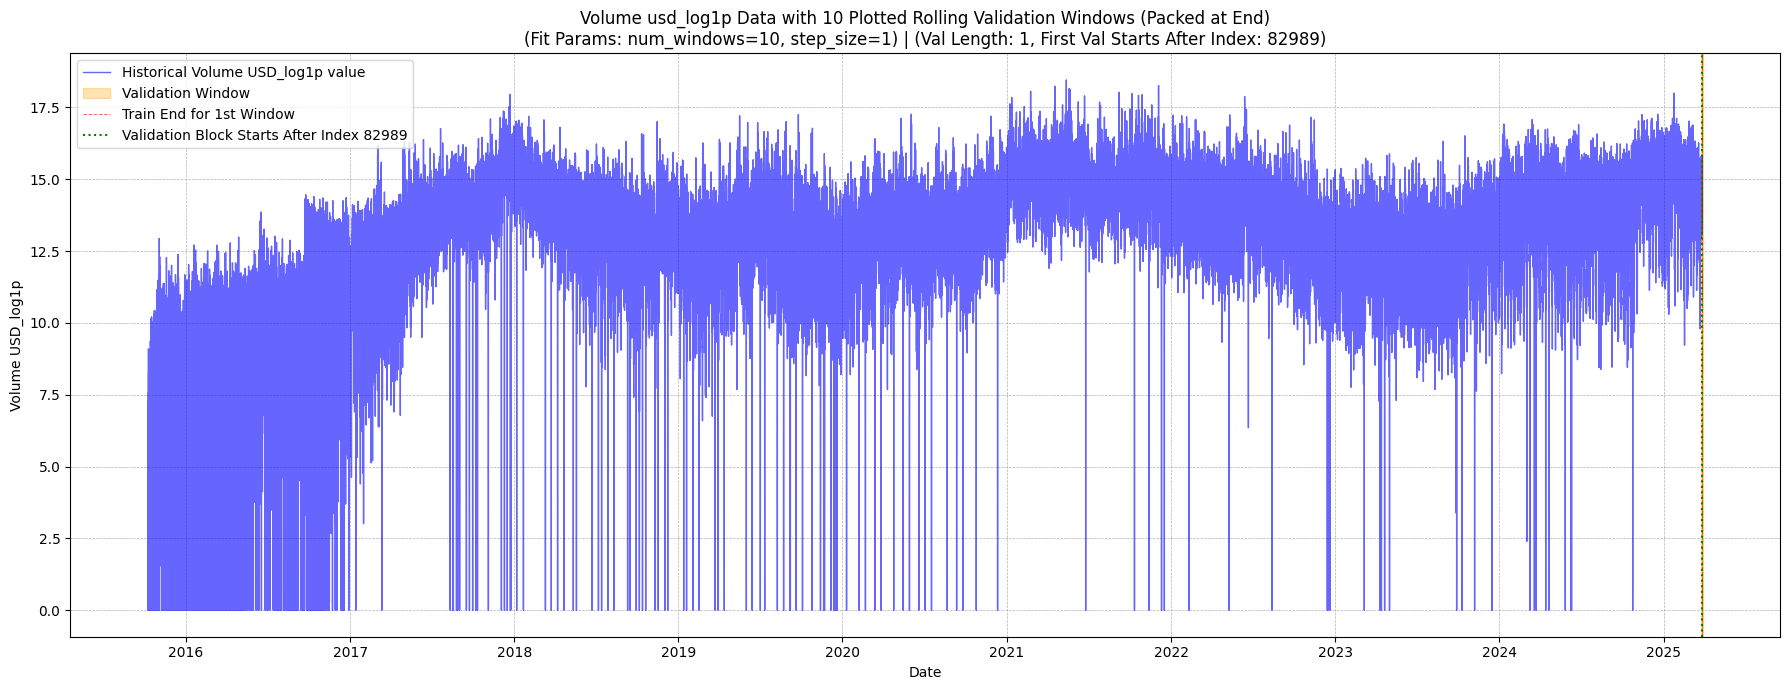

In [11]:
# @title Visualization of Validation Windows (Packed at End)
# --- Visualization of Validation Windows ---
if num_val_windows_actual > 0 and len(validation_windows_for_plot) > 0:
    # Use the full train_data (as used by fit) for visualization context
    # Ensure train_data is defined and not None
    if 'train_data' not in locals() or train_data is None:
        raise NameError("'train_data' is not defined. Please run the '@title Prepare TimeSeriesDataFrame' cell.")
    viz_df = train_data.reset_index().set_index("timestamp")

    # Ensure calculated_min_train_before_val is defined (should be from Cell 10)
    if 'calculated_min_train_before_val' not in locals():
        raise NameError("'calculated_min_train_before_val' is not defined. Please ensure the '@title Validation Window Calculation & Setup (Packed at End)' cell ran successfully.")

    print(f"\nVisualizing {len(validation_windows_for_plot)} calculated validation window locations (packed at end)...")

    plt.figure(figsize=(18, 7)) # Slightly wider figure
    # Plot the entire series used in TimeSeriesDataFrame for context
    plt.plot(viz_df.index, viz_df[target], label=f"Historical {target} value", color="blue", alpha=0.6, linewidth=1.0)

    # Highlight the validation periods - these should now be clustered at the end
    for i, (start_idx_plot, end_idx_plot) in enumerate(validation_windows_for_plot):
        # Ensure indices are within the bounds of the visualization dataframe
        if start_idx_plot < len(viz_df.index) and end_idx_plot <= len(viz_df.index):
            # Highlight the validation span
            plt.axvspan(viz_df.index[start_idx_plot], viz_df.index[end_idx_plot - 1], # end_idx is exclusive, so use -1 for span
                          color="orange", alpha=0.3,
                          label="Validation Window" if i == 0 else None) # Label only the first one

            # Optional: Add a vertical line indicating the end of the training data for this specific validation split
            train_end_idx_plot = start_idx_plot -1
            # Only draw train end line for the first window for clarity
            if train_end_idx_plot >= 0 and i == 0:
                 plt.axvline(viz_df.index[train_end_idx_plot], color='red', linestyle='--', linewidth=0.7, alpha=0.6, label="Train End for 1st Window")

        else:
             print(f"Warning: Skipping visualization for plot window {i+1} due to index out of bounds.")

    # --- THIS IS THE CORRECTED PART ---
    # Add vertical line indicating where the block of validation windows starts
    # Use 'calculated_min_train_before_val' which holds the index AFTER which the first window starts.
    # The line should be drawn at the index BEFORE this.
    val_block_train_end_idx = calculated_min_train_before_val - 1
    if num_val_windows_actual > 0 and val_block_train_end_idx >= 0 and val_block_train_end_idx < len(viz_df.index):
         # Draw line at the end of the training period for the first validation window in the block
         plt.axvline(viz_df.index[val_block_train_end_idx], color='green', linestyle=':', linewidth=1.5,
                     label=f'Validation Block Starts After Index {val_block_train_end_idx}')
    # --- END OF CORRECTION ---

    # Construct the title dynamically
    strategy_title = backtest_strategy.replace('_', ' ').title()
    # Make sure calculated_min_train_before_val exists before using it in f-string
    first_val_starts_after = calculated_min_train_before_val - 1 if 'calculated_min_train_before_val' in locals() else 'N/A'
    plot_title = (f"{target.capitalize()} Data with {len(validation_windows_for_plot)} Plotted {strategy_title} Validation Windows (Packed at End)\n"
                  f"(Fit Params: num_windows={num_val_windows_actual}, step_size={val_step_size_actual}) | "
                  f"(Val Length: {prediction_length}, First Val Starts After Index: {first_val_starts_after})")


    plt.title(plot_title, fontsize=12) # Adjust font size if needed
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend(loc='upper left')
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the plot to Google Drive results folder
    save_path = os.path.join(results_dir, f'{file_path_prefix}val_win.png')
    try:
        plt.savefig(save_path)
        print(f"\nValidation setup visualization saved to: {save_path}")
    except Exception as e:
        print(f"\nError saving validation setup plot: {e}")

    plt.show()
else:
    # Ensure calculated_min_train_before_val is defined before attempting to print failure reason
    reason = ""
    if 'num_val_windows_actual' in locals() and num_val_windows_actual <= 0:
        reason = " (num_val_windows_actual <= 0)"
    elif 'validation_windows_for_plot' in locals() and not validation_windows_for_plot:
        reason = " (validation_windows_for_plot list is empty)"
    print(f"\nSkipping validation window visualization{reason}.")

In [12]:
# @title Define Metric, Quantiles & Initialize Predictor
# --- Define the evaluation metric and quantiles ---
error_metric = "WQL"  # Changed from "RMSE" to Weighted Quantile Loss
desired_quantiles = [0.05, 0.5, 0.95] # For 90% interval + median

print(f"\nUsing evaluation metric: {error_metric}")
print(f"Predicting quantiles: {desired_quantiles}")
print(f"Selected backtest strategy: {backtest_strategy}")

# Check if the given date is older or equal to today's date (logic seems related to saving results)
print(f"Training a new model, this will take up to {max_train_dur//60//60} hours")

# --- Initialize the TimeSeriesPredictor with new metric and quantiles ---
print(f"\nInitializing Predictor. Models will be optimized based on negative {error_metric}.")
print(f"Models will be saved locally during runtime to: {models_dir}")

predictor = TimeSeriesPredictor(
    freq=frequency,
    prediction_length=prediction_length,
    target=target,
    eval_metric=error_metric,       # Use the chosen metric "WQL"
    path=models_dir,                # Use local Colab path for model artifacts during training
    quantile_levels=desired_quantiles # Specify the quantiles to predict and evaluate
)

print(f"\nPredictor initialized. Ready for fitting.")


Using evaluation metric: WQL
Predicting quantiles: [0.05, 0.5, 0.95]
Selected backtest strategy: rolling
Training a new model, this will take up to 8 hours

Initializing Predictor. Models will be optimized based on negative WQL.
Models will be saved locally during runtime to: drive/MyDrive/code_projects/btc_forecast/models/1h_Volume USD_log1p_rolling

Predictor initialized. Ready for fitting.


In [13]:
# @title Fit Predictor
# --- Fit the predictor ---
print(f"\nStarting model training using {len(train_data)} data points available in TimeSeriesDataFrame...")

# Use the calculated number of windows and step size for the fit method
fit_num_val_windows = num_val_windows_actual
fit_val_step_size = max(1, val_step_size_actual) if fit_num_val_windows > 0 else 1 # Ensure step is at least 1 if windows exist

if fit_num_val_windows > 0:
     print(f"Fitting with validation using {fit_num_val_windows} {backtest_strategy.replace('_',' ')} windows.")
     print(f"Using val_step_size = {fit_val_step_size} in predictor.fit().")
else:
     print("Fitting without validation windows (num_val_windows=0).")

# Example hyperparameter tuning settings (customize as needed)
# hpo_tune_kwargs = {
#      'num_trials': 15,        # Max number of HPO trials (adjust based on time_limit)
#      'searcher': 'random',    # 'random' (default), 'skopt', ...
#      'scheduler': 'local',    # 'local' (default), ...
#  }
# Set to None or "auto" to use AutoGluon's defaults if preferred
# hpo_tune_kwargs = "auto"
hpo_tune_kwargs = None


predictor.fit(
    train_data,                   # Use the full TimeSeriesDataFrame prepared earlier
    presets="best_quality",      # Consider 'fast_training', 'medium_quality', 'high_quality', 'best_quality'
    time_limit=max_train_dur,
    num_val_windows=fit_num_val_windows, # Pass the calculated number of windows
    val_step_size=fit_val_step_size,     # Pass the calculated step size for fit internal logic
    refit_full=False,                     # Refit models on the full train_data after HPO/validation
    hyperparameters=selected_hp,         # Pass the filtered hyperparameter dictionary
    hyperparameter_tune_kwargs=hpo_tune_kwargs, # Pass HPO settings
    enable_ensemble=True
)

print("\nModel training finished.")

Beginning AutoGluon training... Time limit = 28800s
AutoGluon will save models to '/content/drive/MyDrive/code_projects/btc_forecast/models/1h_Volume USD_log1p_rolling'



Starting model training using 83000 data points available in TimeSeriesDataFrame...
Fitting with validation using 10 rolling windows.
Using val_step_size = 1 in predictor.fit().


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.27 GB / 12.67 GB (89.0%)
Disk Space Avail:   171.38 GB / 225.83 GB (75.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'AutoETS': {}, 'DynamicOptimizedTheta': {}},
 'known_covariates_names': [],
 'num_val_windows': 10,
 'prediction_length': 1,
 'quantile_levels': [0.05, 0.5, 0.95],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'Volume USD_log1p',
 'time_limit': 28800,
 'val_step_size': 1,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 83003 rows (NaN fraction=0.0%), 1 t


Model training finished.


In [14]:
# @title Leaderboard Processing, Hyperparameter Extraction & Saving (Combined)

# --- Define serializer function (needs to be defined before use) ---
def default_serializer(obj):
    if isinstance(obj, (np.integer, np.floating, np.bool_)):
        return obj.item() # Convert numpy scalar types to standard Python types
    elif isinstance(obj, np.ndarray):
        return obj.tolist() # Convert numpy arrays to lists
    elif isinstance(obj, pd.Timestamp):
        return obj.isoformat() # Convert pandas Timestamps to ISO format strings
    elif hasattr(obj, 'get_hyperparameters') and callable(getattr(obj, 'get_hyperparameters', None)):
        # Heuristic for AutoGluon space objects - try to get their dict representation
        try:
            return obj.get_hyperparameters()
        except Exception as space_err:
             print(f"Note: Could not serialize AutoGluon space object {type(obj)} using get_hyperparameters: {space_err}. Using string representation.")
             return str(obj) # Fallback to string representation
    elif isinstance(obj, (dict, list, str, int, float, bool, type(None))):
         return obj # Already JSON serializable
    else:
        # Fallback for any other unhandled types
        # print(f"Warning: Serializing unknown type {type(obj)} as string: {str(obj)[:100]}...") # Uncomment for debugging
        return str(obj)

# --- Leaderboard Processing and Hyperparameter Extraction ---
print("\n--- Processing Results ---")
leaderboard_df = pd.DataFrame() # Initialize empty dataframe
all_hyperparams_extracted = {} # Store extracted params before serialization
model_info = {} # Initialize model_info

try:
    # Ensure predictor is defined
    if 'predictor' not in locals():
        raise NameError("'predictor' is not defined. Please ensure the 'Fit Predictor' cell ran successfully.")

    # Get leaderboard based on validation performance during training
    print("Generating leaderboard...")
    # Note: train_data is passed here for context if needed by leaderboard, but scores are from validation during fit
    leaderboard_df = predictor.leaderboard(train_data, silent=True)
    # Sort by score_val: Higher is better for WQL (it's negative WQL), so ascending=False
    leaderboard_df = leaderboard_df.sort_values(["score_val"], ascending=False)

    # Save leaderboard to Google Drive results folder
    leaderboard_save_path = os.path.join(results_dir, f'{file_path_prefix}leaderboard.csv')
    try:
        leaderboard_df.to_csv(leaderboard_save_path, index=False)
        print(f"Leaderboard saved to: {leaderboard_save_path}")
    except Exception as e:
        print(f"Error saving leaderboard to {leaderboard_save_path}: {e}")

    print("\n--- Leaderboard ---")
    display(leaderboard_df.head(50)) # Display top models in Colab output

    # --- Hyperparameter Extraction ---
    print("\n--- Extracting Tuned Hyperparameters ---")
    info_dict = predictor.info() # Get the info dictionary containing model details

    if info_dict and 'model_info' in info_dict:
        model_info = info_dict['model_info'] # Assign model_info here
        print("Successfully retrieved model_info from predictor.")
        # Iterate through models present in the info dictionary
        for model_name in model_info:
            # Optional: Check if this model is actually on the leaderboard before extracting
            # This check might be too strict if leaderboard display issues occurred
            # if model_name not in leaderboard_df["model"].values:
            #      # print(f"Note: Skipping HParams for model '{model_name}' not found on leaderboard.") # Uncomment if needed
            #      continue

            model_details = model_info[model_name]

            # Handle ensembles (extract weights)
            if "WeightedEnsemble" in model_name:
                if 'model_weights' in model_details:
                    # Apply serializer to weights just in case
                    serialized_weights = {k: default_serializer(v) for k, v in model_details['model_weights'].items()}
                    all_hyperparams_extracted[model_name] = {'model_weights': serialized_weights}
                    print(f"Extracted weights for ensemble: {model_name}")
                else:
                    all_hyperparams_extracted[model_name] = "Ensemble weights not found in model_info"
                    print(f"Could not find weights key for ensemble: {model_name}")
            # Handle base models (extract hyperparameters)
            else:
                if 'hyperparameters' in model_details:
                    if model_details['hyperparameters']: # Check if hyperparameters dict is not empty
                        # Apply serializer to each hyperparameter value
                        serializable_params = {}
                        for k, v in model_details['hyperparameters'].items():
                             serializable_params[k] = default_serializer(v)
                        all_hyperparams_extracted[model_name] = serializable_params
                        print(f"Extracted and serialized hyperparameters for: {model_name}")
                    else:
                        all_hyperparams_extracted[model_name] = "Hyperparameters key was present but empty {}"
                        print(f"Hyperparameters key is empty for: {model_name} (Model might have used defaults)")
                else:
                    all_hyperparams_extracted[model_name] = "Hyperparameters key not found in model_info"
                    print(f"Could not find hyperparameters key for: {model_name}")
    else:
        # model_info remains empty or None if 'model_info' key missing
        print("Error: 'model_info' key not found in predictor.info() or info_dict is None. Cannot extract hyperparameters or check ensembles.")
        model_info = None # Ensure it's None if not retrieved

    # --- Save Hyperparameters to JSON ---
    # Use the 'all_hyperparams_extracted' dictionary populated above
    hyperparams_file_path = os.path.join(results_dir, f'{file_path_prefix}tuned_hps.json') # Corrected filename if needed
    try:
        if all_hyperparams_extracted: # Check the correct dictionary
            print(f"\nSaving extracted and serialized hyperparameters to: {hyperparams_file_path}")
            # We already applied the serializer during extraction
            with open(hyperparams_file_path, 'w') as f:
                 json.dump(all_hyperparams_extracted, f, indent=4)
            print("Hyperparameters JSON saved successfully.")
        else:
             print("Skipping saving hyperparameters JSON as none were successfully extracted.")
    except TypeError as e:
         print(f"ERROR saving hyperparameters to JSON due to TypeError: {e}")
         print("This likely means a value wasn't properly serialized by default_serializer.")
    except Exception as e:
         print(f"Error saving hyperparameters to JSON file {hyperparams_file_path}: {e}")


    # --- Check Specific Ensemble Weights (Integrated) ---
    if model_info: # Only proceed if model_info was retrieved
        ensemble_to_check = "WeightedEnsemble"
        actual_ensemble_name = None
        # Find the actual ensemble name
        full_ensemble_names = [name for name in model_info.keys() if ensemble_to_check in name and "FULL" in name]
        if full_ensemble_names:
            actual_ensemble_name = full_ensemble_names[0]
            print(f"\nFound ensemble likely from refit_full: {actual_ensemble_name}")
        else:
            any_ensemble_names = [name for name in model_info.keys() if "WeightedEnsemble" in name] # Find any ensemble
            if any_ensemble_names:
                 actual_ensemble_name = any_ensemble_names[-1] # Often the last one is the main one
                 print(f"\nFound ensemble (potentially from validation stage or refit): {actual_ensemble_name}")

        if actual_ensemble_name and actual_ensemble_name in model_info:
            print(f"\nChecking details for ensemble model: {actual_ensemble_name}")
            ensemble_details = model_info[actual_ensemble_name]

            if 'model_weights' in ensemble_details:
                base_model_weights = ensemble_details['model_weights']
                print(f"\nBase models included in '{actual_ensemble_name}' and their weights:")
                active_models = {model: weight for model, weight in base_model_weights.items() if weight > 1e-6} # Use threshold for float weights
                sorted_weights = sorted(active_models.items(), key=lambda item: item[1], reverse=True)
                if sorted_weights:
                    for model, weight in sorted_weights:
                        print(f"- {model}: {weight:.4f}")
                else:
                    print("No base models found with significant non-zero weights in this ensemble.")
            else:
                print(f"Could not find 'model_weights' key for the selected ensemble '{actual_ensemble_name}'.")
        elif model_info: # Check again if model_info exists but ensemble name wasn't found
            print(f"\nModel containing '{ensemble_to_check}' or similar not found in predictor.info()['model_info'].")
            available_models = list(model_info.keys())
            print(f"Available models in model_info: {available_models}")
            ensemble_models_found = [m for m in available_models if "Ensemble" in m]
            if ensemble_models_found:
                print(f"Found other ensemble models: {ensemble_models_found}.")

    else: # Case where model_info was None from the start
         print("\nCannot check ensemble weights as 'model_info' could not be retrieved earlier.")


except NameError as e:
     print(f"ERROR in Leaderboard/HP Processing: Required variable not defined. {e}")
     import traceback
     traceback.print_exc()
except Exception as e:
    print(f"\nAn error occurred during leaderboard generation or hyperparameter extraction: {e}")
    print("Proceeding with caution, results might be incomplete.")
    import traceback
    traceback.print_exc()

data with frequency 'None' has been resampled to frequency 'h'.



--- Processing Results ---
Generating leaderboard...


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


Leaderboard saved to: drive/MyDrive/code_projects/btc_forecast/results/1h_Volume USD_log1p_rolling/2025-04-08_1h_Volume USD_log1p_rolling_leaderboard.csv

--- Leaderboard ---


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
1,WeightedEnsemble,-0.0094,-0.0143,1.1888,1.3005,2.6437,3
2,DynamicOptimizedTheta,-0.0094,-0.0143,1.1830,1.3005,61.2044,1
0,AutoETS,-0.0084,-0.0152,1.7746,2.5626,20.9873,2



--- Extracting Tuned Hyperparameters ---
Successfully retrieved model_info from predictor.
Hyperparameters key is empty for: DynamicOptimizedTheta (Model might have used defaults)
Hyperparameters key is empty for: AutoETS (Model might have used defaults)
Extracted weights for ensemble: WeightedEnsemble

Saving extracted and serialized hyperparameters to: drive/MyDrive/code_projects/btc_forecast/results/1h_Volume USD_log1p_rolling/2025-04-08_1h_Volume USD_log1p_rolling_tuned_hps.json
Hyperparameters JSON saved successfully.

Found ensemble (potentially from validation stage or refit): WeightedEnsemble

Checking details for ensemble model: WeightedEnsemble

Base models included in 'WeightedEnsemble' and their weights:
- DynamicOptimizedTheta: 1.0000


data with frequency 'None' has been resampled to frequency 'h'.



--- Generating Forecast ---
Generating forecast for the next 1 step(s) following the training data...


Model not specified in predict, will default to the model with the best validation score: DynamicOptimizedTheta


Forecast generated successfully (log1p scale).
Forecast DataFrame head (log1p scale):


,,mean,0.05,0.5,0.95
item_id,timestamp,,,,
BTC/USD,2025-03-28,13.7490,12.6918,13.7874,15.0825



Reverting forecasts back to the original 'Volume USD' scale using expm1...
Forecasts reverted to original scale:


,,mean,0.05,0.5,0.95
item_id,timestamp,,,,
BTC/USD,2025-03-28,935690.9554,325080.7757,972263.6844,3550214.0261



Generating plot on the original 'Volume USD' scale...

Forecast plot (original scale) saved to: drive/MyDrive/code_projects/btc_forecast/results/1h_Volume USD_log1p_rolling/2025-04-08_1h_Volume USD_log1p_rolling_forecasts_WQL.png


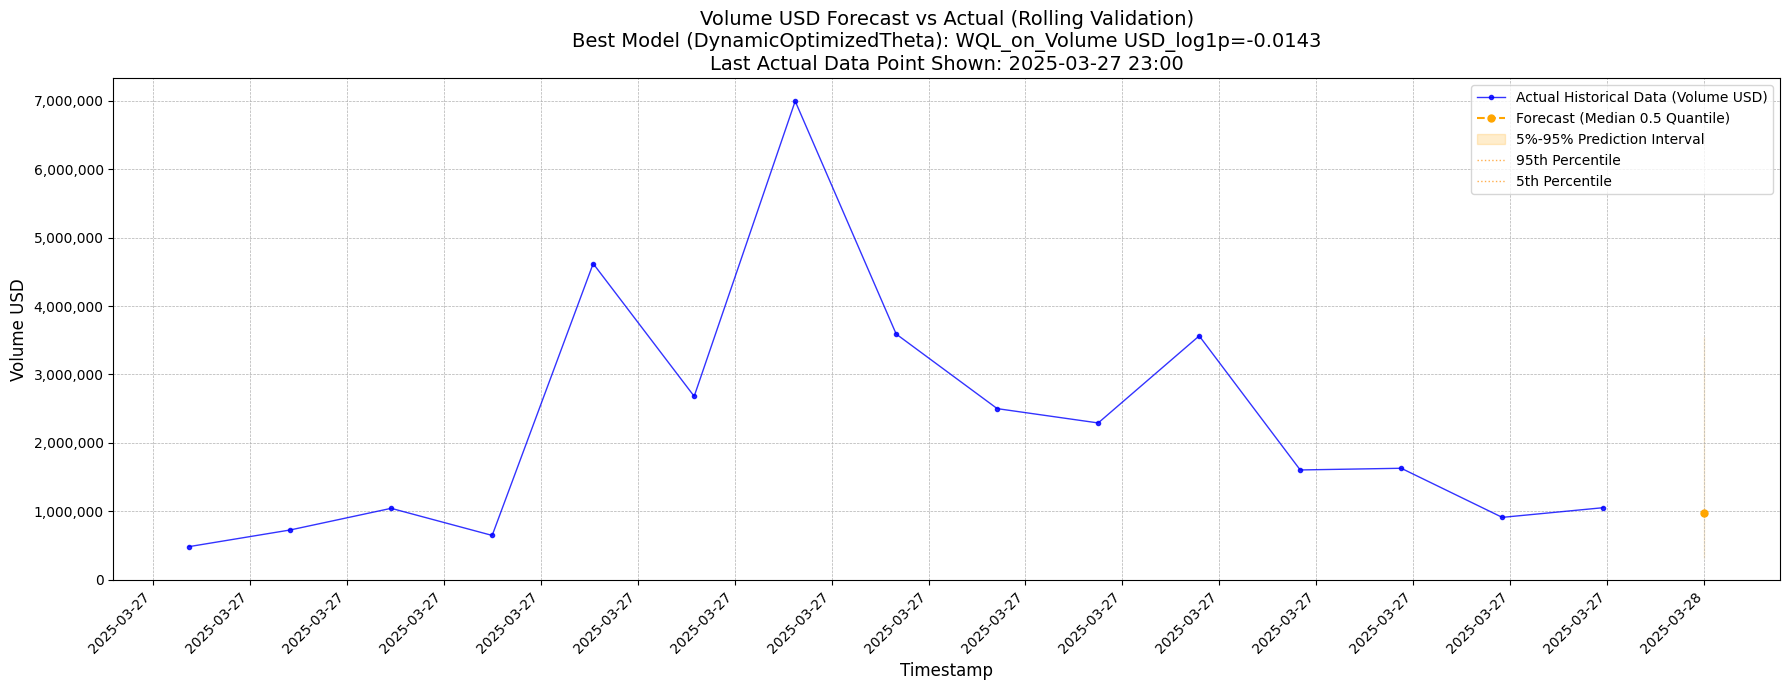

In [15]:
# @title Generate and Plot Forecasts (with Reversion)
# --- Generate and Plot Forecasts ---
print("\n--- Generating Forecast ---")
# --- Parameters for Visualization ---
# How many historical points to show before the forecast starts
history_points_to_show = prediction_length * 15 # Show more history for context
# Plot formatting
x_lbl_bins = 20 # Max number of x-axis labels
x_lbl_rot = 45  # Rotation for x-axis labels

# --- Generate Forecasts (on the transformed log1p scale) ---
print(f"Generating forecast for the next {prediction_length} step(s) following the training data...")
try:
    # Ensure predictor and train_data exist
    if 'predictor' not in locals() or 'train_data' not in locals():
         raise NameError("Predictor or train_data not defined. Ensure previous cells ran.")

    # Predict based on the *entire* train_data used for fitting
    forecasts_log1p = predictor.predict(train_data) # Forecasts are on log1p scale
    print("Forecast generated successfully (log1p scale).")
    print("Forecast DataFrame head (log1p scale):")
    display(forecasts_log1p.head())

    # --- Revert Forecasts back to Original Scale ---
    print("\nReverting forecasts back to the original 'Volume USD' scale using expm1...")
    cols_to_revert = [col for col in forecasts_log1p.columns if col not in ['item_id', 'timestamp']]
    forecasts_original_scale = forecasts_log1p.copy()
    for col in cols_to_revert:
         forecasts_original_scale[col] = np.expm1(forecasts_log1p[col])
         forecasts_original_scale[col] = forecasts_original_scale[col].clip(lower=0)
    print("Forecasts reverted to original scale:")
    display(forecasts_original_scale.head())


    # --- Prepare Data for Plotting (Using Original Scale) ---
    # 1. Get the ORIGINAL historical data for the plot context
    if 'df_filtered' not in locals():
         raise NameError("'df_filtered' not defined. Ensure the Prepare TimeSeriesDataFrame cell ran.")
    # Use .copy() to avoid SettingWithCopyWarning if you modify this later
    actual_data_original_for_plot = df_filtered.iloc[-history_points_to_show:].copy()

    # 2. Prepare the reverted forecasts for plotting
    # Reset index - the index becomes a column, likely named 'timestamp'
    forecasts_original_for_plot = forecasts_original_scale.reset_index()
    # <<< Check the actual column name created by reset_index >>>
    # print("Columns in forecasts_original_for_plot:", forecasts_original_for_plot.columns)
    # <<< Assuming the column is named 'timestamp' based on error >>>
    time_col_name_forecast = 'timestamp' # Use 'timestamp'


    # --- Create the Plot (on Original Scale) ---
    print("\nGenerating plot on the original 'Volume USD' scale...")
    plt.figure(figsize=(18, 7)) # Wider figure

    # 1. Plot the ORIGINAL historical actual data
    if 'target_raw' not in locals():
         target_raw = "Volume USD"
         print(f"Warning: 'target_raw' not defined, assuming '{target_raw}' for original column name.")
    # Use the 'date' column from the original filtered data
    plt.plot(
        actual_data_original_for_plot["date"], # Use 'date' column from df_filtered source
        actual_data_original_for_plot[target_raw],
        label=f'Actual Historical Data ({target_raw})',
        color='blue', marker='.', linestyle='-', linewidth=1.0, alpha=0.8
    )

    # 2. Plot the REVERTED MEDIAN forecast
    median_quantile_col = str(desired_quantiles[1])
    if median_quantile_col in forecasts_original_for_plot.columns:
        plt.plot(
            forecasts_original_for_plot[time_col_name_forecast], # <<< Use time_col_name_forecast >>>
            forecasts_original_for_plot[median_quantile_col],
            label=f'Forecast (Median {median_quantile_col} Quantile)',
            color='orange', linestyle='--', marker='o', markersize=5
        )
    elif 'mean' in forecasts_original_for_plot.columns:
        print("Note: Plotting reverted 'mean' forecast as median quantile column not found.")
        plt.plot(
            forecasts_original_for_plot[time_col_name_forecast], # <<< Use time_col_name_forecast >>>
            forecasts_original_for_plot['mean'],
            label='Forecast (Mean)', color='red', linestyle=':', marker='x'
        )
    else:
        print(f"Warning: Neither median quantile column '{median_quantile_col}' nor 'mean' column found.")


    # 3. Plot the REVERTED confidence/prediction interval
    lower_quantile_col = str(desired_quantiles[0])
    upper_quantile_col = str(desired_quantiles[2])

    if lower_quantile_col in forecasts_original_for_plot.columns and upper_quantile_col in forecasts_original_for_plot.columns:
        plt.fill_between(
            forecasts_original_for_plot[time_col_name_forecast], # <<< Use time_col_name_forecast >>>
            forecasts_original_for_plot[lower_quantile_col],
            forecasts_original_for_plot[upper_quantile_col],
            color='orange', alpha=0.2,
            label=f'{int(desired_quantiles[0]*100)}%-{int(desired_quantiles[2]*100)}% Prediction Interval'
        )
        plt.plot(
             forecasts_original_for_plot[time_col_name_forecast], # <<< Use time_col_name_forecast >>>
             forecasts_original_for_plot[upper_quantile_col],
             color='darkorange', linestyle=':', linewidth=1, alpha=0.7, label=f'{int(desired_quantiles[2]*100)}th Percentile'
        )
        plt.plot(
             forecasts_original_for_plot[time_col_name_forecast], # <<< Use time_col_name_forecast >>>
             forecasts_original_for_plot[lower_quantile_col],
             color='darkorange', linestyle=':', linewidth=1, alpha=0.7, label=f'{int(desired_quantiles[0]*100)}th Percentile'
        )
    else:
        print(f"Warning: Reverted quantile columns '{lower_quantile_col}' or '{upper_quantile_col}' not found.")

    # --- Formatting ---
    strategy_title = backtest_strategy.replace('_', ' ').title()
    y_label = target_raw
    title = f"{y_label} Forecast vs Actual Data ({strategy_title} Validation Strategy Used)"

    if 'leaderboard_df' in locals() and not leaderboard_df.empty:
        try:
            best_score_val = leaderboard_df["score_val"].max()
            best_model_name = leaderboard_df.iloc[leaderboard_df['score_val'].idxmax()]['model']
            # Use 'date' column from actual_data_original_for_plot for consistency in display
            last_actual_ts_str = actual_data_original_for_plot['date'].iloc[-1].strftime('%Y-%m-%d %H:%M')
            title = (f"{y_label} Forecast vs Actual ({strategy_title} Validation)\n"
                     f"Best Model ({best_model_name}): {error_metric}_on_{target}={best_score_val:.4f}\n"
                     f"Last Actual Data Point Shown: {last_actual_ts_str}")
        except Exception as e:
            print(f"Could not get leaderboard info for plot title: {e}")
    elif not actual_data_original_for_plot.empty:
         last_actual_ts_str = actual_data_original_for_plot['date'].iloc[-1].strftime('%Y-%m-%d %H:%M')
         title += f"\nLast Actual Data Point Shown: {last_actual_ts_str}"


    plt.title(title, fontsize=14)
    # Update X label to reflect the column name used
    plt.xlabel(time_col_name_forecast.capitalize(), fontsize=12) # <<< Use variable for label >>>
    plt.ylabel(y_label, fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=x_lbl_bins))
    plt.xticks(rotation=x_lbl_rot, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()

    # --- Save the Plot ---
    plot_save_path = os.path.join(results_dir, f'{file_path_prefix}forecasts_{error_metric}.png')
    try:
        plt.savefig(plot_save_path, dpi=150)
        print(f"\nForecast plot (original scale) saved to: {plot_save_path}")
    except Exception as e:
        print(f"\nError saving forecast plot to {plot_save_path}: {e}")

    plt.show()

except FileNotFoundError as e:
     print(f"Error during prediction: {e}. Did predictor train successfully?")
except NameError as e:
     print(f"Error: A required variable might not be defined. {e}")
     import traceback
     traceback.print_exc()
except Exception as e:
    print(f"\nAn error occurred during forecast generation or plotting: {e}")
    import traceback
    traceback.print_exc()